<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/03_missing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Missing data handling

This notebook explores and handles the missing data.

In [51]:
import numpy as np
import pandas as pd
import missingno as msno

In [52]:
df = pd.read_parquet('https://github.com/philipp-lampert/mymandible/blob/main/data_science/data/processed_data.parquet?raw=true')

As a first step we will remove all columns that contain data only meant for descriptive purposes but that are not useful as predictors. In addition, these variables are conditional, meaning they are not applicable to all rows which leads to a lot of missing data inside these columns that cannot be imputed.

In [53]:
date_columns = [column for column in df.columns if column.startswith("days_to_")]
date_columns.remove('days_to_follow_up')
other_columns = ['which_autoimmune_disease', 'which_bleeding_disorder', 'long_plate_thickness', 'mini_plate_thickness', 'tmj_replacement_type']
remove_columns = date_columns + other_columns

df = df.drop(columns=remove_columns)

First let's explore how much of data is actually missing. Since our dataset has a large number of target variables, we will look at predictors and targets separately.

<Axes: >

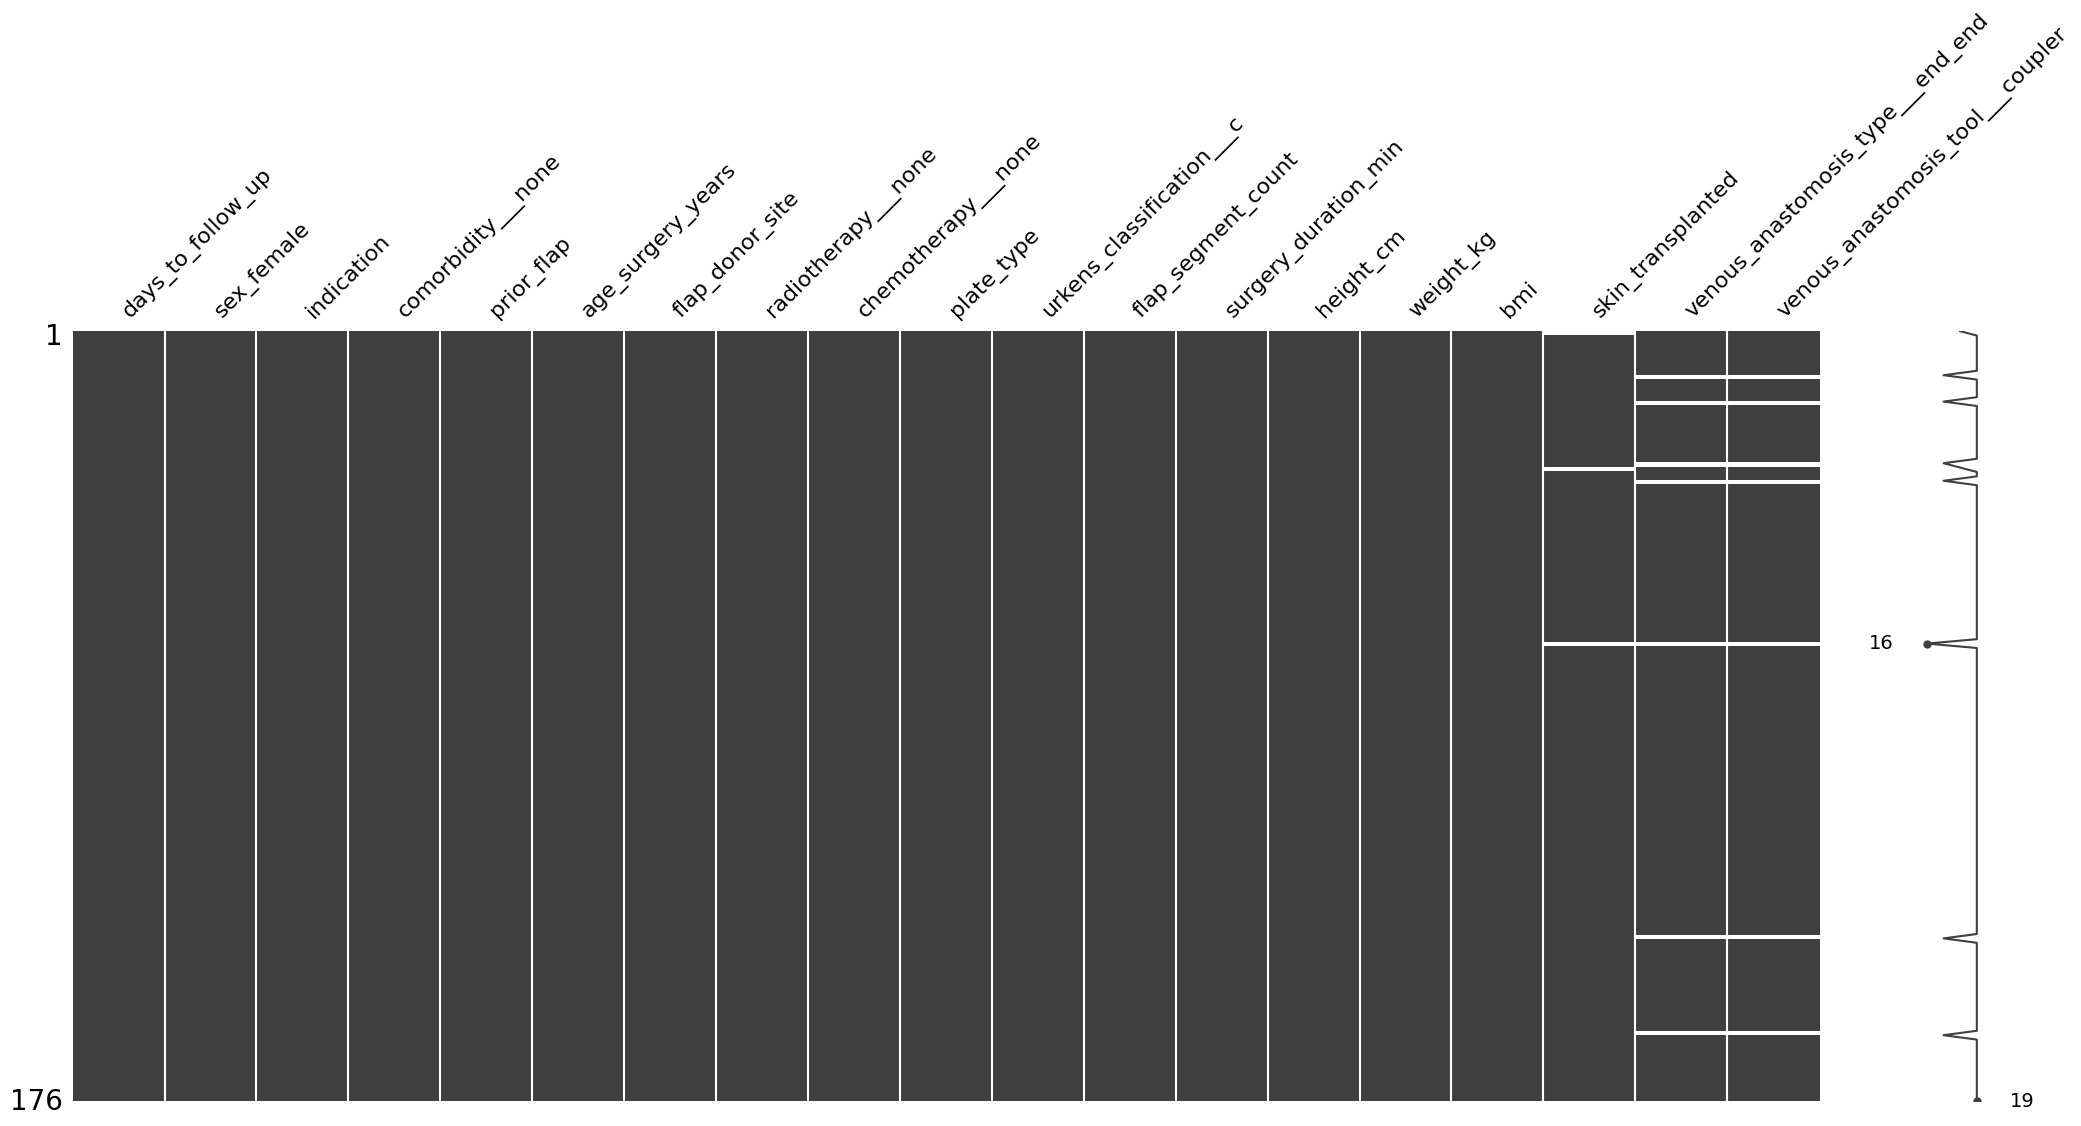

In [54]:
unique_predictors = ['days_to_follow_up', 'sex_female', 'indication', 'comorbidity___none', 'prior_flap', 'age_surgery_years', 'flap_donor_site', 'radiotherapy___none', 'chemotherapy___none', 'plate_type', 'urkens_classification___c', 'flap_segment_count', 'surgery_duration_min', 'height_cm', 'weight_kg', 'bmi', 'skin_transplanted', 'venous_anastomosis_type___end_end', 'venous_anastomosis_tool___coupler']
msno.matrix(df[unique_predictors])

That looks very good. We have very few missing data within our predictor variables. What can also be seen in the matrix is the variables that do contain missing values are closely related. All of them are derived from the surgery report which sometimes does not specify the information queried here.

<Axes: >

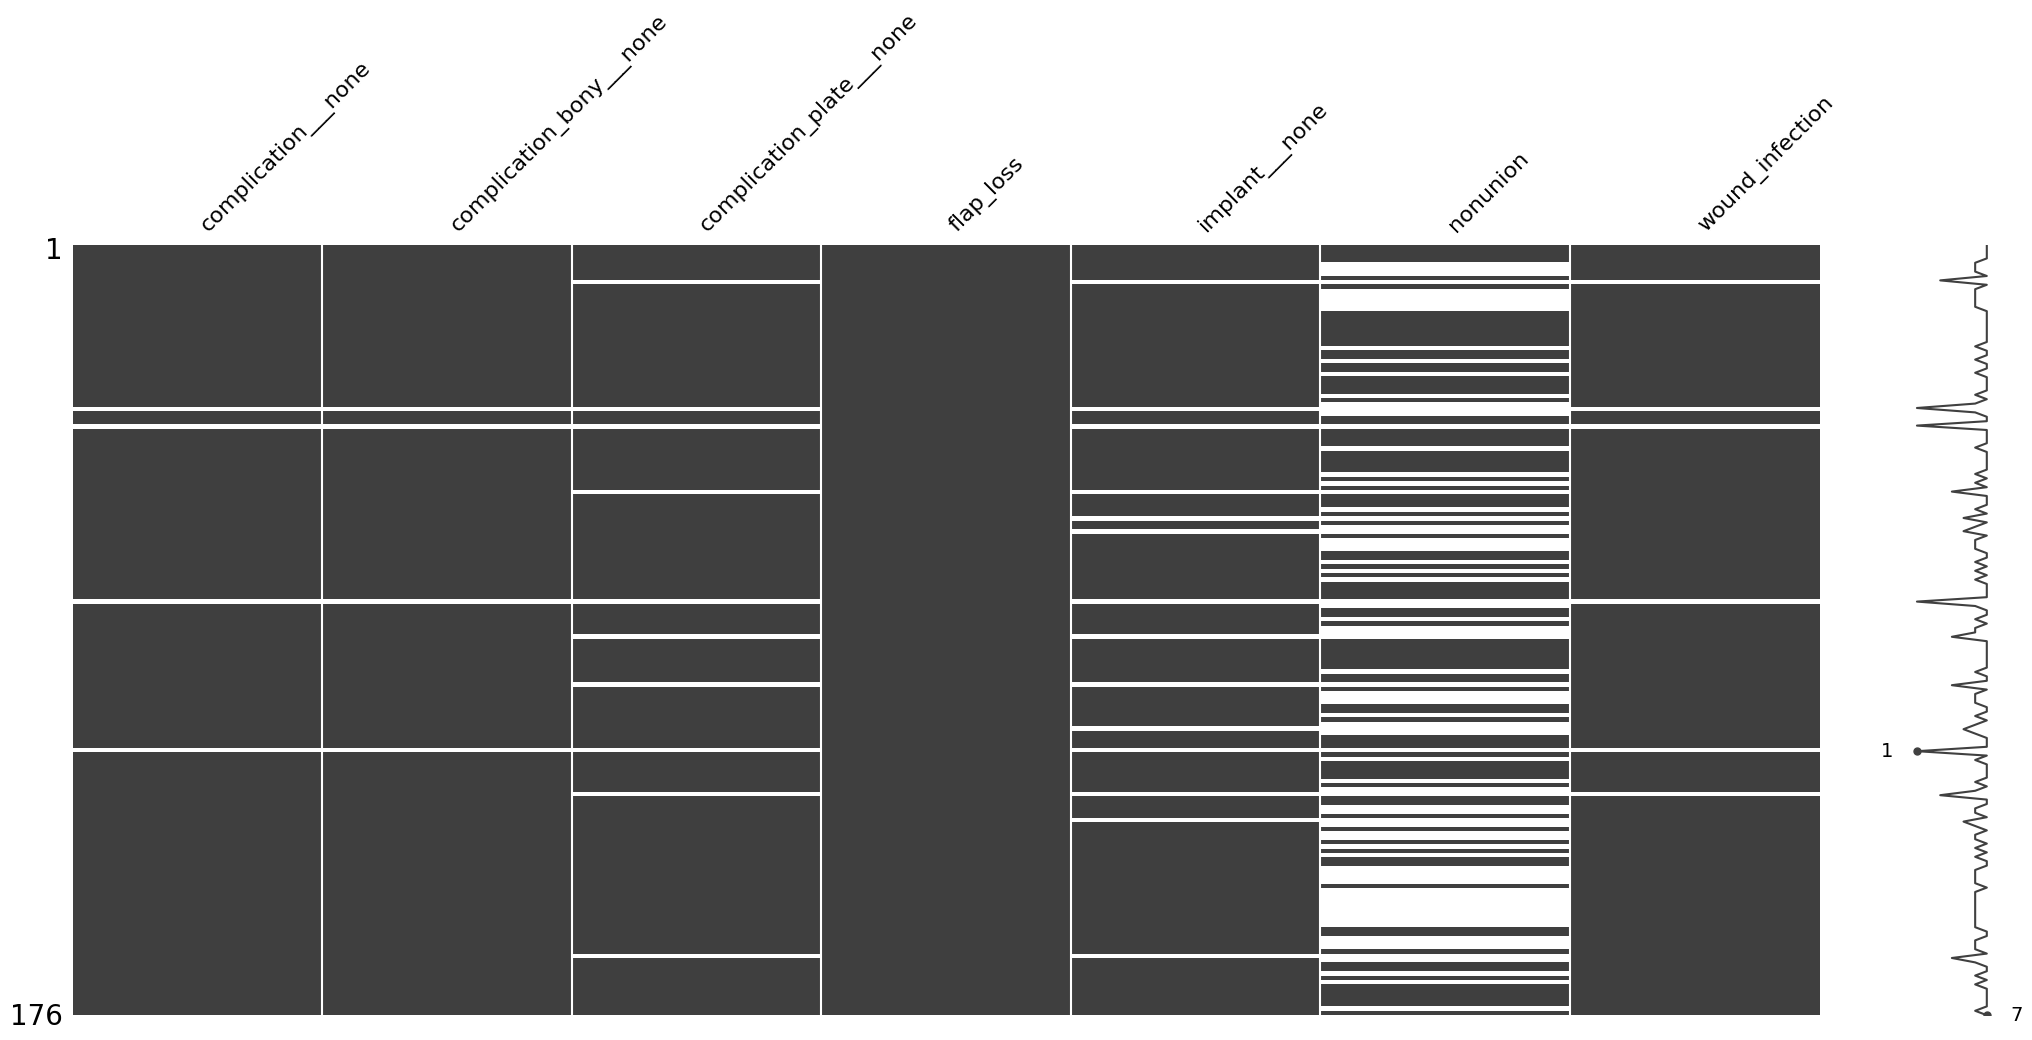

In [55]:
unique_outcomes = ['complication___none', 'complication_bony___none', 'complication_plate___none', 'flap_loss', 'implant___none', 'nonunion', 'wound_infection']
msno.matrix(df[unique_outcomes])

The one variable standing out amongst the target variables is nonunion. This is because a nonunion can only be diagnosed in radiological imaging and in order for it to be comparable only within a specified time frame after surgery (6 to 12 months). Not all patients received imaging wihtin that time, leading to more missing values than usual.

Almost all of the missing data within the other target variables is due to logical reasons: If the flap was lost very early after surgery (not that `flap_loss` does not have any missing values) we decided to mark all other outcomes as missing, as those complications did not have enough time to develop before the flap was lost.

##Dealing with missing values

There are algortihms that can natively handle missing data. One of those is the popular XGBoost algorithm.

In [56]:
df.to_parquet('01_data_with_missing')

The easiest way to deal with missing values for algorithms that cannot handle missing data is by removing all rows with any missing data (in the predictor columns only, as outcome variables differ for each analysis). This is also called complete-case-analysis.

In [57]:
first_outcome_var = df.columns.get_loc('flap_loss')
predictors = df.columns[:first_outcome_var].tolist()
predictors = predictors.remove('flap_revision')
df_cca = df.dropna(subset=predictors)
df_cca.to_parquet('02_data_cca')

However, this is a relatively wasteful technique given that only very few variables have missing values.

Many sophisticated imputation methods exist although none of them likely beats a well estimated guess based on expert knowledge. In addition, the variables containting missing values (e.g. venous anasotmosis details) are almost completely unrelated to other predictor variables which makes imputation based on non-missing data very unreliable.

We have thus decided to solely rely on imputing the clinically most probable guess for predictor variables. It should be noted that this technique can only be used if the percentage of missing values is very small, as is the case in our dataset.


In [58]:
values = {
    'skin_transplanted': False,
    'venous_anastomosis_tool___coupler': False,
    'venous_anastomosis_tool___suture': True,
    'venous_anastomosis_type___end_end': True,
    'venous_anastomosis_type___end_side': False
}

df_imputed = df.fillna(value=values)
df_imputed.to_parquet('03_data_imputed')